In [1]:
# TODO #599: sedimentation?
# TODO #599: reintroduce products used in animations (?)
# TODO #599: table with execution times
# TODO #599: multiple realisations?
# TODO #599: move EulerianAdvection and AmbientThermodynamics next to each other so that async call is not affecting timing

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [3]:
import string
import os

import numpy as np
from scipy.io import netcdf_file
from scipy.ndimage import uniform_filter1d
import matplotlib
from matplotlib import pyplot

from PySDM.exporters import NetCDFExporter, VTKExporter
from PySDM_examples.utils import ProgBarController
from open_atmos_jupyter_utils import show_plot
import PySDM.products as PySDM_products
from PySDM.physics import si
from PySDM import Formulae
from PySDM.initialisation import spectra

from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.Szumowski_et_al_1998 import Simulation, Storage
from PySDM_examples.UIUC_2021.commons import FREEZING_CONSTANTS, LOGNORMAL_MODE_SURF_A, LOGNORMAL_SGM_G


In [4]:
formulae = Formulae(
    freezing_temperature_spectrum='Niemand_et_al_2012',
    heterogeneous_ice_nucleation_rate='ABIFM',
    constants=FREEZING_CONSTANTS["dust"]
)

lognormal_mode_A = LOGNORMAL_MODE_SURF_A
lognormal_sgm_g = LOGNORMAL_SGM_G
inp_frac = 1 / (270 + 45 + 1)

conc_cld_unit = '1/cc'
conc_ice_unit = '1/l'
cool_rate_unit = 'K/min'
wall_time_unit = 'ms'

In [5]:
runs = (
    {'settings': {'rhod_w_max': 1.2 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 1.2 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
    {'settings': {'rhod_w_max': 0.6 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 0.6 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
    {'settings': {'rhod_w_max': 0.3 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 0.3 * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
)

In [6]:
products = (
    PySDM_products.DynamicWallTime(
        'Condensation', name='Condensation_wall_time', unit=wall_time_unit
    ),
        PySDM_products.DynamicWallTime(
        'Displacement', name='Displacement_wall_time', unit=wall_time_unit
    ),
    PySDM_products.DynamicWallTime(
        'Freezing', name='Freezing_wall_time', unit=wall_time_unit
    ),
    PySDM_products.DynamicWallTime(
        'EulerianAdvection', name='EulerianAdvection_wall_time', unit=wall_time_unit
    ),
    PySDM_products.ParticleConcentration(
        radius_range=(-np.inf, 0*si.um), name='n_i', unit=conc_ice_unit, stp=True
    ),
    PySDM_products.ParticleConcentration(
        radius_range=(1*si.um, np.inf), name='n_c', unit=conc_cld_unit, stp=True
    ),
    PySDM_products.CoolingRate(
        unit=cool_rate_unit
    ),
    PySDM_products.IceNucleiConcentration(
        name='n_inp', unit=conc_ice_unit, stp=True
    ),
    PySDM_products.FrozenParticleConcentration(
        name='n_frozen_aerosols',
        unit=conc_ice_unit,
        count_activated=False,
        count_unactivated=True,
        stp=True
    ),
    PySDM_products.FrozenParticleConcentration(
        name='n_frozen_droplets',
        unit=conc_ice_unit,
        count_activated=True,
        count_unactivated=False,
        stp=True
    )
)

In [7]:
for i, run in enumerate(runs):
    folder = f"output/rhod_w_max={run['settings']['rhod_w_max']}_singular={run['settings']['freezing_singular']}"
    os.makedirs(folder, exist_ok=True)
    
    run['ncfile'] = f'{folder}/out.nc'
    
    settings = Settings(formulae)
    settings.dt = 2.5 * si.s
    settings.output_interval = settings.dt * 12
    settings.simulation_time = 6000 * si.second if 'CI' not in os.environ else 2 * settings.output_interval
    settings.spin_up_time = 600 * si.second
    settings.size = (1500, 500)
    settings.n_sd_per_gridbox = 64
    settings.grid = (60, 20)
    settings.th_std0 -= 33.3 * si.kelvins
    settings.qv0 -= 6.66 * si.grams / si.kilogram
    
    settings.processes['coalescence'] = False
    settings.processes['freezing'] = True
    settings.freezing_inp_spec = spectra.Lognormal(
        norm_factor=1,
        m_mode=lognormal_mode_A,
        s_geom=lognormal_sgm_g
    )
    settings.freezing_inp_frac = inp_frac
    settings.freezing_thaw = True

    settings.kappa = 0.61
    settings.mode_1 = spectra.Lognormal(
        norm_factor=(270 + 270/315) / si.centimetre**3 / formulae.constants.rho_STP,
        m_mode=0.03 * si.micrometre,
        s_geom=1.28,
    )
    settings.mode_2 = spectra.Lognormal(
        norm_factor=(45 + 45/315) / si.centimetre**3 / formulae.constants.rho_STP,
        m_mode=0.14 * si.micrometre,
        s_geom=1.75,
    )
    settings.spectrum_per_mass_of_dry_air = spectra.Sum((settings.mode_1, settings.mode_2))
    
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)

    storage = Storage()
    simulation = Simulation(settings, storage, SpinUp=SpinUp)
    simulation.reinit(products)

    vtk_exporter = VTKExporter(path=folder)    
    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"), vtk_exporter=vtk_exporter)
    vtk_exporter.write_pvd()

    ncdf_exporter = NetCDFExporter(storage, settings, simulation, run['ncfile'])
    ncdf_exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

In [8]:
def label(settings):
    lbl = str({k.replace('condensation_', ''):
               f"{v:.1e}" if isinstance(v, float) else
               str(v).zfill(2) if isinstance(v, int) else
               v for k, v in settings.items()})
    return lbl\
        .replace('{', '')\
        .replace('}', '')\
        .replace("'", '')\
        .replace('rhod_w_max:', '$w_{max}\\approx$')\
        .replace('e+00', r' m/s')\
        .replace('6.0e-01', '0.6 m/s')\
        .replace('3.0e-01', '0.3 m/s')\
        .replace('freezing_singular: True', r'singular$\,\,\,$')\
        .replace('freezing_singular: False', 'time-dep')

$w_{max}\approx$ 1.2 m/s, time-dep: time=4.18ms
$w_{max}\approx$ 1.2 m/s, singular$\,\,\,$: time=0.82ms
$w_{max}\approx$ 0.6 m/s, time-dep: time=3.55ms
$w_{max}\approx$ 0.6 m/s, singular$\,\,\,$: time=0.77ms
$w_{max}\approx$ 0.3 m/s, time-dep: time=3.75ms
$w_{max}\approx$ 0.3 m/s, singular$\,\,\,$: time=0.32ms
$w_{max}\approx$ 1.2 m/s, time-dep: time=4.18ms
$w_{max}\approx$ 1.2 m/s, singular$\,\,\,$: time=0.82ms
$w_{max}\approx$ 0.6 m/s, time-dep: time=3.55ms
$w_{max}\approx$ 0.6 m/s, singular$\,\,\,$: time=0.77ms
$w_{max}\approx$ 0.3 m/s, time-dep: time=3.75ms
$w_{max}\approx$ 0.3 m/s, singular$\,\,\,$: time=0.32ms
$w_{max}\approx$ 1.2 m/s, time-dep: time=4.18ms
$w_{max}\approx$ 1.2 m/s, singular$\,\,\,$: time=0.82ms
$w_{max}\approx$ 0.6 m/s, time-dep: time=3.55ms
$w_{max}\approx$ 0.6 m/s, singular$\,\,\,$: time=0.77ms
$w_{max}\approx$ 0.3 m/s, time-dep: time=3.75ms
$w_{max}\approx$ 0.3 m/s, singular$\,\,\,$: time=0.32ms
$w_{max}\approx$ 1.2 m/s, time-dep: time=4.18ms
$w_{max}\approx$

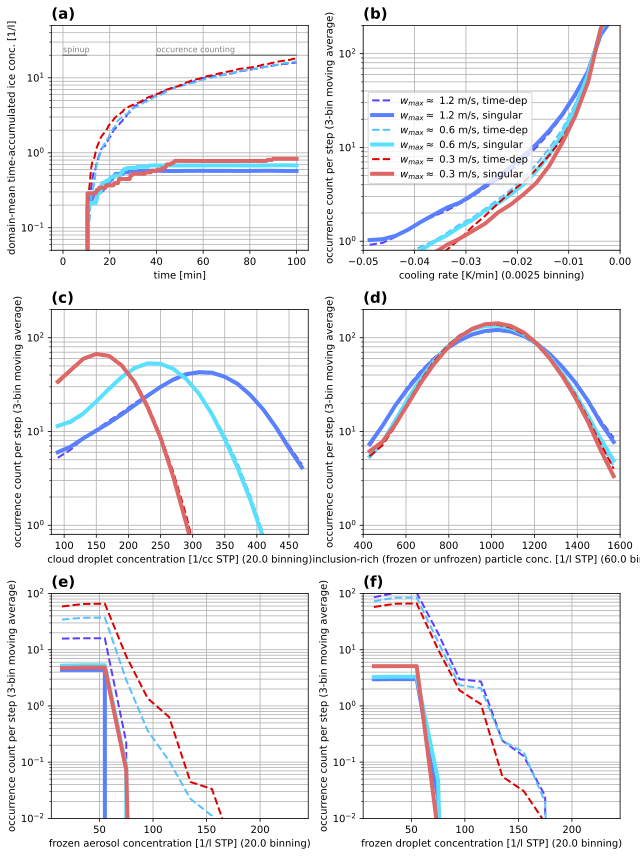

HTML(value="<a href='./figures.pdf' target='_blank'>./figures.pdf</a><br>")

In [10]:
matplotlib.rcParams["figure.figsize"] = (9, 12)
colors = (
    '#5940ff', '#5980ff', '#59c0ff', '#59e0ff', 
    '#dd0000', '#dd6666', '#dd9999', '#ddcccc', 
    '#777777', '#aaaaaa'
)
n_last_output_steps = 120 if 'CI' not in os.environ else 2
bins = {
    'n_i': 20,
    'cooling rate': 20,
    'n_c': 20,
    'n_inp': 20,
    'n_frozen_aerosols': 12,
    'n_frozen_droplets': 12
}
bin_range = {
    'n_i': None,
    'cooling rate': (-.05, 0),
    'n_c': (80, 480),
    'n_inp': (400, 1600),
    'n_frozen_aerosols': (5, 245),
    'n_frozen_droplets': (5, 245)
}
window = 3

rows = 3
columns = 2

fig, axs = pyplot.subplots(rows, columns, sharey=False, tight_layout=True)
for plot_i, var in enumerate(bin_range.keys()):
    if len(axs.shape) == 2:
        ax = axs[plot_i//columns][plot_i%columns]
    else:
        ax = axs[plot_i]
    for i, run in enumerate(runs):
        nc = netcdf_file(run['ncfile'], mode='r', mmap=False)
        n_spinup = nc.n_spin_up // nc.steps_per_output_interval
        data = nc.variables[var]
        timesteps = slice(-(n_last_output_steps+1), None)
        assert data.shape[0] >= n_last_output_steps
        
        style = {
            'color': colors[i], 
            'lw': 4 if run['settings']['freezing_singular'] else 2,
            'ls': '--' if not run['settings']['freezing_singular'] else '-'
        }
        
        if var != 'n_i':
            wall_time = np.nanmean(nc.variables['Freezing_wall_time'][timesteps] / nc.steps_per_output_interval)
            wall_time = np.nan if not np.isfinite(wall_time) else int(100 * wall_time) / 100
            lbl = label(run['settings'])
            print(f"{lbl}: time={wall_time:.2f}{wall_time_unit}")      

            y, x, _ = ax.hist(
                data[timesteps, :, :].flatten(), 
                bins=bins[var],
                range=bin_range[var],
                histtype='step', 
                color=colors[i],
                lw=0
            )
            y /= n_last_output_steps
            filt_x = x[:-1] if window % 2 == 0 else (x[1:] + x[:-1])/2
            ax.plot(
                filt_x,
                uniform_filter1d(y, size=window),
                **style,
                label=f"{lbl}"
            )
            if i == 0:
                ax.set_yscale('log')
                ax.set_ylabel('occurrence count per step ' + f'({window}-bin moving average)')
                binwidth = (bin_range[var][1]-bin_range[var][0])/bins[var]
                ax.set_xlim(bin_range[var])
                ax.set_ylim(.8, 200)
                if var == 'n_inp':
                    ax.set_xlabel(f'inclusion-rich (frozen or unfrozen) particle conc. [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_frozen_aerosols':
                    ax.set_ylim(.01, 100)
                    ax.set_xlabel(f'frozen aerosol concentration [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_frozen_droplets':
                    ax.set_ylim(.01, 100)
                    ax.set_xlabel(f'frozen droplet concentration [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_c':
                    ax.set_xlabel(f'cloud droplet concentration [{conc_cld_unit} STP] ({binwidth} binning)')
                elif var == 'cooling rate':
                    ax.set_xlabel(f'cooling rate [{cool_rate_unit}] ({binwidth} binning)')
                else:
                    assert False
        else:
            ax.plot(
                nc.variables['T'][:] / si.min,
                np.mean(np.mean(data[:,:,:], axis=1), axis=1) ,
                **style
            )
            if i == 0:
                ax.set_yscale('log')
                ax.set_ylim(.05, 50)
                ax.set_ylabel(f'domain-mean time-accumulated ice conc. [{conc_ice_unit}]')
                ax.set_xlabel('time [min]')
                for note, times in {
                    "spinup": [0, min(n_spinup, len(nc.variables['T'][:])-1)],
                    "occurence counting": [timesteps.start, -1]
                }.items():
                    x = nc.variables['T'][times] / si.min
                    y = 20
                    ax.plot(
                        x,
                        [y] * 2,
                        color='gray'
                    )
                    ax.text(x[0], 1.1 * y, note, color='gray', size=8)
                
    ax.grid(which='minor')
    ax.grid(which='major')
    if var == 'cooling rate':
        ax.legend()
    ax.text(
        0, 1.03,
        '('+string.ascii_lowercase[plot_i]+')',
        transform=ax.transAxes,
        size=15,
        weight='bold'
    )
show_plot("figures.pdf")